In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json,toml

from deep_entropy_scaling.deep_entropy_scaling import *

In [6]:
saft = pd.read_csv( "demo_data/saft_paras_demo.csv" )
saft

,names,molarweight,m,sigma,epsilon_k,mu,kappa_ab,epsilon_k_ab,isomeric_smiles
0,butan-1-ol,74.073,3.140383,3.432248,256.079712,0,0.004223,2444.189697,CCCCO


In [7]:
sample_no = 20

# triple point temperature butanol: 184.54 K
data = {
    "temperature": np.linspace(80.54,450,sample_no),
    "pressure": np.ones(sample_no)*1e4,
    "state": ["liquid"]*sample_no,
}
data=pd.DataFrame(data)

para_cols = ['molarweight', 'm','sigma', 'epsilon_k', 'kappa_ab','epsilon_k_ab','mu']
for pcol in para_cols:
    data[pcol] = saft[pcol].iloc[0]

data = data.apply( get_resd_entropy , axis=1 )
data = data.apply( get_CE_viscosity_reference_new , axis=1 )
    
data.head()

,temperature,pressure,state,molarweight,m,sigma,epsilon_k,kappa_ab,epsilon_k_ab,mu,resd_entropy,molar_density,red_temperature,red_density,ln_eta_ref_new
0,80.540000,10000.0,liquid,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,8.074437,14448.698257,0.314511,0.351816,-13.125569
1,99.985263,10000.0,liquid,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,7.266018,13608.668532,0.390446,0.331362,-12.928944
2,119.430526,10000.0,liquid,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,6.741373,13177.520399,0.466380,0.320864,-12.759319
3,138.875789,10000.0,liquid,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,6.304945,12826.467507,0.542315,0.312316,-12.610445
4,158.321053,10000.0,liquid,74.073,3.140383,3.432248,256.079712,0.004223,2444.189697,0,5.923793,12521.710341,0.618249,0.304895,-12.478296


In [8]:
model_path = "model0/"

with open(model_path+'best_trained_model_paras.toml', 'r') as toml_file:
    model_hyperparas = toml.load( toml_file)
    
with open(model_path+'train_val_test_norm.json', 'r') as json_file:
    train_val_test_norm = json.load( json_file)    

paranet_layer_units = [ int(model_hyperparas["paranet_layer_units"]) ]* model_hyperparas["paranet_layer_no"]
refnet_layer_units  = [ int(model_hyperparas["refnet_layer_units"]) ]* model_hyperparas["refnet_layer_no"]    
    
model = DeepEntropyNet( 7, int(model_hyperparas["num_used_features"]),   
                 num_used_features=int(model_hyperparas["num_used_features"]), 
                 paranet_layer_units=paranet_layer_units,
                 refnet_layer_units=refnet_layer_units,
                 batch_norm=model_hyperparas["batch_norm"],
                 use_base=model_hyperparas["use_base"] )    
    
model.load_state_dict(torch.load(model_path+"/best_trained_model.state_dict") ) #, map_location=device))

[7, 50, 50, 6]
[9, 12, 12, 1]

paranet

linear io 7 50
batch_norm size 50
relu
linear io 50 50
batch_norm size 50
relu
linear io 50 6

refnet

linear io 9 12
batch_norm size 12
relu
linear io 12 12
batch_norm size 12
relu
linear io 12 1


<All keys matched successfully>

In [9]:

dataset = DeepEntropyDataset( data, train_val_test_norm, int(model_hyperparas["num_used_features"])-1  )
    

In [10]:
y_pred = model(dataset.X_norm).detach().numpy()

In [11]:
experimental_data = pd.read_csv("demo_data/butanol_data.csv")
experimental_data["viscosity"] = experimental_data["viscosity"]/1000

para_cols = ['molarweight', 'm','sigma', 'epsilon_k', 'kappa_ab','epsilon_k_ab','mu']
for pcol in para_cols:
    experimental_data[pcol] = saft[pcol].iloc[0]

experimental_data = experimental_data.apply( get_resd_entropy , axis=1 )
experimental_data = experimental_data.apply( get_CE_viscosity_reference_new , axis=1 )


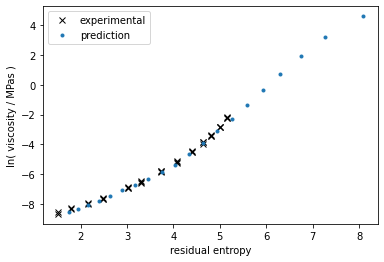

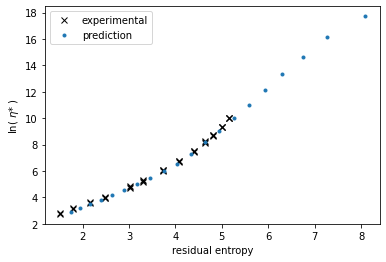

In [12]:
y  = np.squeeze( dataset.unormy(y_pred) )
yy = np.exp( y )
y_exp = experimental_data["viscosity"]

plt.plot( experimental_data["resd_entropy"], np.log(y_exp), "kx", label="experimental" )
plt.plot( data["resd_entropy"], y, ".", label="prediction" )
plt.legend()
plt.xlabel("residual entropy")
plt.ylabel("ln( viscosity / MPas )")
plt.show()
plt.close()

y_exp_2  = np.log( y_exp )- experimental_data["ln_eta_ref_new"]
y_2     = y - data["ln_eta_ref_new"]

plt.plot( experimental_data["resd_entropy"], y_exp_2, "kx", label="experimental" )
plt.plot( data["resd_entropy"], y_2, ".", label="prediction" )
plt.legend()
plt.xlabel("residual entropy")
plt.ylabel(r"ln( $\eta$* )")
plt.show()
plt.close()

